In [1]:
import time
start_time = time.time()

In [2]:
import logging
from pathlib import Path

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

from dask.distributed import Client

from stein_thinning.thinning import thin

import lotka_volterra
import utils.caching
from utils.caching import cached, cached_batch, subscriptable
from utils.ksd import calculate_ksd
from utils.parallel import apply_along_axis_parallel, get_map_parallel
from utils.paths import FIGURES_PATH, GENERATED_DATA_PATH
from utils.plotting import centered_subplots, highlight_points, plot_paths, plot_sample_thinned, plot_traces
from utils.sampling import to_arviz

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
figures_path = FIGURES_PATH

Directory where results of expensive calculations will be stored:

In [6]:
utils.caching.cache_dir = GENERATED_DATA_PATH

In [7]:
recalculate = False  # True => perform expensive calculations, False => use stored results
save_data = recalculate

We create a Dask client in order to parallelise calculations where possible:

In [8]:
client = Client(processes=True, threads_per_worker=4, n_workers=4, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39621,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:36899,Total threads: 4
Dashboard: http://127.0.0.1:36507/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:34751,


In [9]:
map_parallel = get_map_parallel(client)

In [10]:
n_chains = len(lotka_volterra.theta_inits)

Read-only input datasets:

In [11]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_samples() -> list[np.ndarray]:
    raise NotImplemented

In [12]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def hmc_samples() -> list[np.ndarray]:
    raise NotImplemented

In [13]:
@subscriptable(n=n_chains)
@cached(read_only=True)
def rw_grads(i: int) -> np.ndarray:
    raise NotImplemented

In [14]:
@subscriptable(n=n_chains)
@cached(read_only=True)
def hmc_grads(i: int) -> np.ndarray:
    raise NotImplemented

# Apply Stein thinning

### Random-walk sample

In [15]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

In [16]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def rw_thinned_idx() -> list[np.ndarray]:
    # we have to instantiate the array here as the caching function currently cannot be serialised
    samples = list(rw_samples)
    gradients = list(rw_grads)
    def calculate(i):
        return thin(np.exp(samples[i]), gradients[i], n_points_calculate, preconditioner='med')
    return map_parallel(calculate, range(n_chains))

Force recalculation when necessary:

In [17]:
%%time
#rw_thinned_idx.recalculate(persist=True);

CPU times: user 0 ns, sys: 5 μs, total: 5 μs
Wall time: 9.54 μs


#### Log-transformation

Since inference is performed in log-space, it is natural to try Stein thinning in log-space as well.

If $\xi_i = \log \theta_i$, then by the chain rule we have
$$\frac{\partial f}{\partial \xi_i} = \sum_{j=1}^d \frac{\partial f}{\partial \theta_j} \frac{\partial \theta_j}{\partial \xi_i},$$
thus
$$\nabla_{\pmb{\xi}} \log p(\pmb{\xi}) = J^{-T} \nabla_{\pmb{\theta}} \log p(\pmb{\theta}),$$
where the Jacobian is $J = \text{diag}(\theta_1^{-1}, \dots, \theta_d^{-1})$, so $J^{-T} =  \text{diag}(\theta_1, \dots, \theta_d)$.

In [18]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def rw_st_log_idx() -> list[np.ndarray]:
    # we have to instantiate the array here as the caching function currently cannot be serialised
    samples = list(rw_samples)
    gradients = list(rw_grads)
    def calculate(i):
        return thin(samples[i], np.exp(samples[i]) * gradients[i], n_points_calculate, preconditioner='med')
    return map_parallel(calculate, range(n_chains))

Force recalculation when necessary:

In [19]:
%%time
#rw_st_log_idx.recalculate(persist=True);

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 7.87 μs


This reproduces the results shown in Figure S20 in the Supplementary Material:

In [20]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_st_log_idx_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_st_log_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_st_log_idx_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_st_log_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_2
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_st_log_idx_2
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_st_log_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_3
DEBUG:

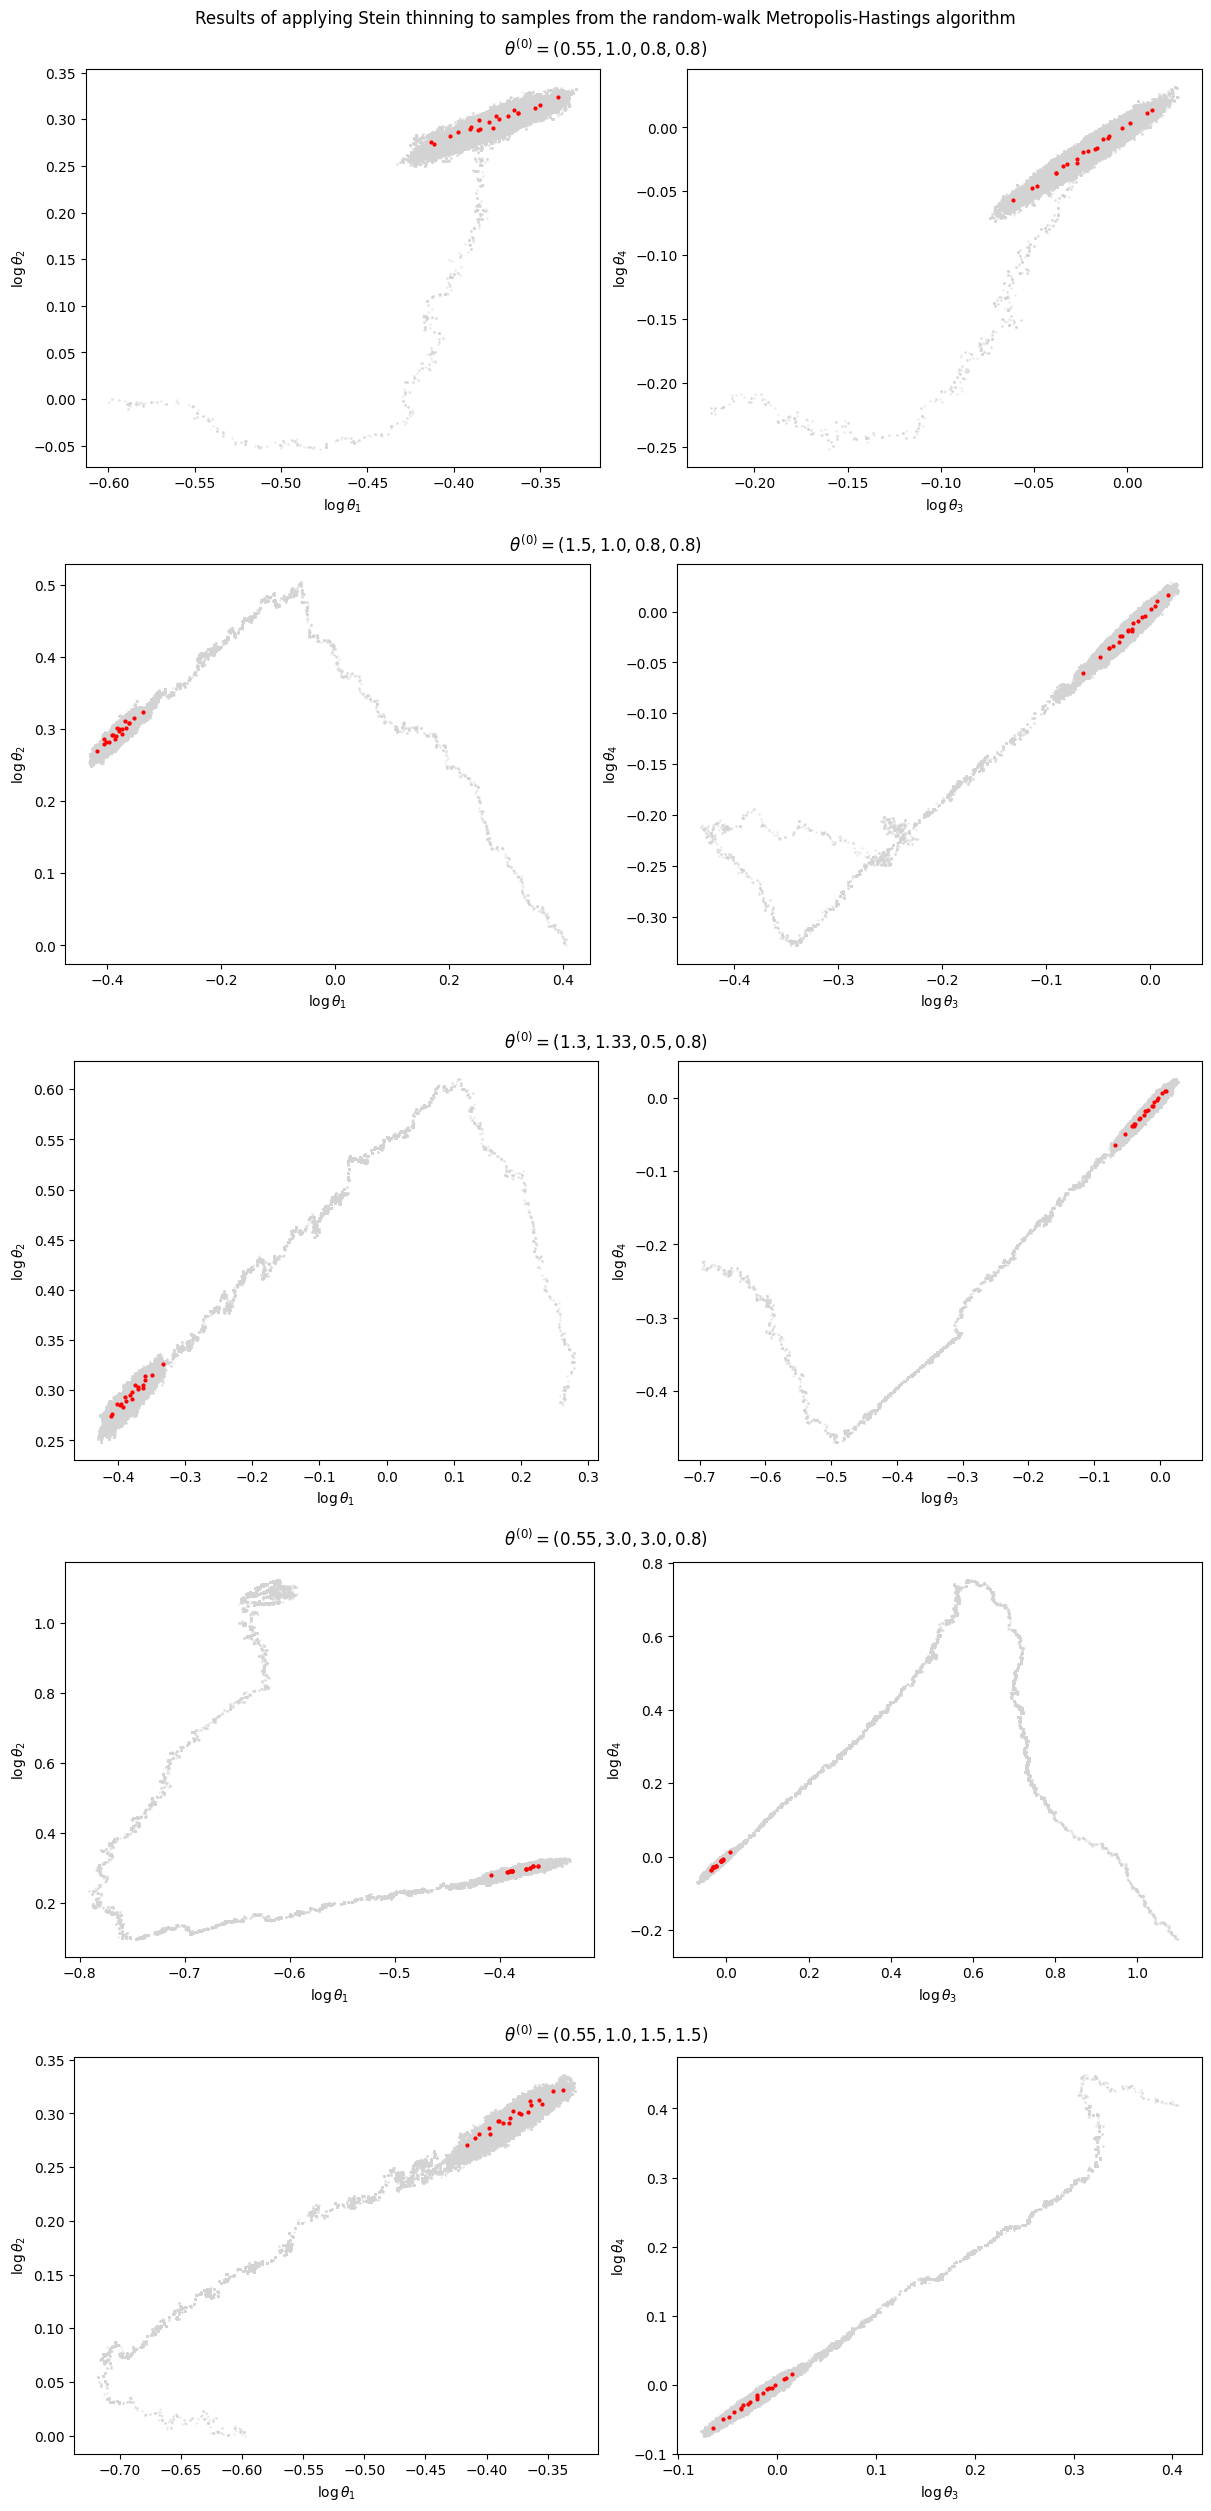

In [21]:
fig = plot_sample_thinned(rw_samples, rw_st_log_idx, titles, var_labels, n_points=n_points_display);
fig.savefig(figures_path / 'lotka-volterra-stein-thinning.png', dpi=300);
fig.suptitle('Results of applying Stein thinning to samples from the random-walk Metropolis-Hastings algorithm');

### HMC sample

In [22]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def hmc_thinned_idx(i: int) -> np.ndarray:
    return thin(np.exp(hmc_samples[i]), hmc_grads[i], n_points_thinned, preconditioner='med')

DEBUG:utils.caching:Reading from disk cache: hmc_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/hmc_thinned_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/hmc_thinned_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_2
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_2
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/hmc_thinned_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: h

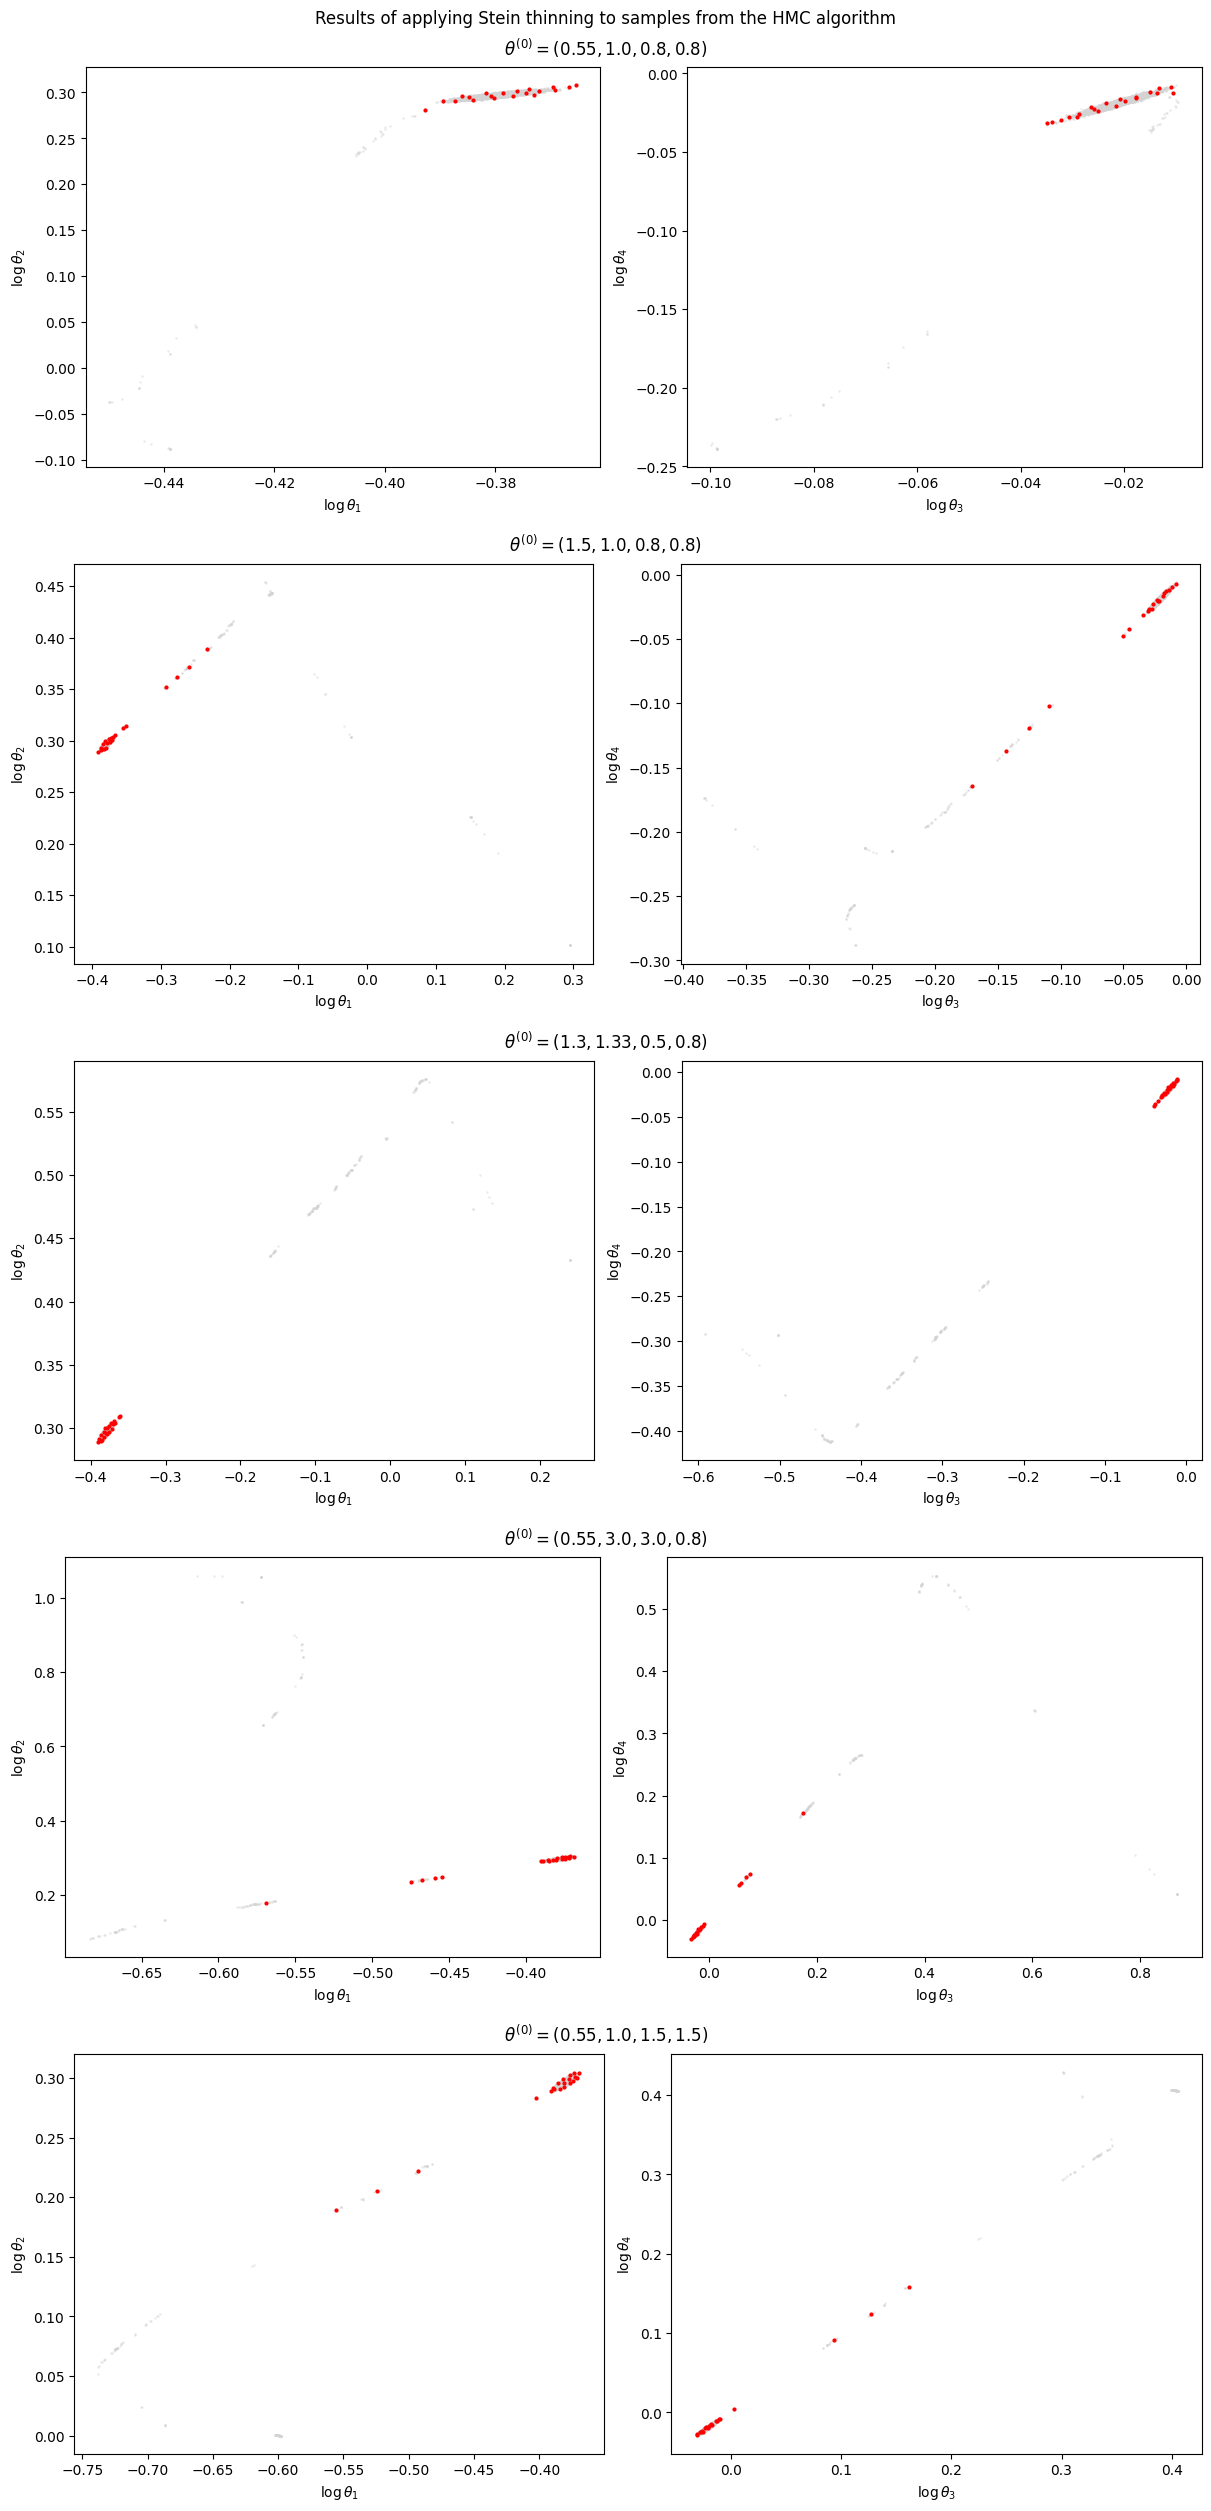

In [23]:
fig = plot_sample_thinned(hmc_samples, hmc_thinned_idx, titles, var_labels);
fig.suptitle('Results of applying Stein thinning to samples from the HMC algorithm');

In [24]:
time.time() - start_time

45.10659337043762